In [131]:
# import necessary libraries 
from cvxopt import matrix, solvers # cvxopt is the quadratic programming library for lagrange optimization 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import matplotlib
from mlxtend.plotting import plot_decision_regions # for visualizing decision boundaries in machine learning models, especially for binary and multiclass classification problems.
from sklearn.model_selection import GridSearchCV #  This class is a part of scikit-learn's model selection module and is used for hyperparameter tuning of machine learning models.
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics # The metrics module in scikit-learn provides a collection of functions and classes for evaluating the performance of machine learning models. 
import contextlib # Python module that provides utilities for working with context management, particularly through the use of the with statement.
from sklearn.base import BaseEstimator, ClassifierMixin
import warnings
# BaseEstimator: This is the base class for all scikit-learn estimators. It provides a consistent interface for working with machine learning models, ensuring that custom models can be easily integrated into scikit-learn workflows.
# ClassifierMixin: This is a mixin class specifically designed for classification models. It provides default implementations for common classification-related methods, such as accuracy calculation.

In [132]:
# Loading the text file 
def load_txt(file_name):
    with open(file_name, 'r') as file:
        # Skip the first 7 lines
        for _ in range(7):
            next(file)
        # Load numerical data from the remaining lines
        data = np.loadtxt(file, delimiter='\t') # [data] is a 2D array of rows and columns according to the data in the text file
    return data

In [133]:
load_txt('Aggregation.txt')

array([[15.55, 28.65,  2.  ],
       [14.9 , 27.55,  2.  ],
       [14.45, 28.35,  2.  ],
       ...,
       [ 8.5 ,  3.25,  5.  ],
       [ 8.1 ,  3.55,  5.  ],
       [ 8.15,  4.  ,  5.  ]])

In [134]:
def linearkernel(X, Z, degree, intercept, gamma):
    """
    Compute the linear kernel between two sets of data points.

    Parameters:
    - X (numpy.ndarray): Data points of the first set (shape: n_samples1 x n_features).
    - Z (numpy.ndarray): Data points of the second set (shape: n_samples2 x n_features).
    - degree (int): Unused parameter for compatibility with other kernel functions.
    - intercept (float): Unused parameter for compatibility with other kernel functions.
    - gamma (float): Unused parameter for compatibility with other kernel functions.

    Returns:
    - numpy.ndarray: Gram matrix containing the pairwise linear kernel values between data points.
    """
    # Compute the dot product of data points
    kernel_matrix = np.dot(X, Z.T)

    return kernel_matrix


In [135]:
def poly_kernel(x, z, degree, intercept, gamma):
    """
    Compute the polynomial kernel between two sets of data points.

    Parameters:
    - x (numpy.ndarray): Data points of the first set (shape: n_samples1 x n_features).
    - z (numpy.ndarray): Data points of the second set (shape: n_samples2 x n_features).
    - degree (int): The degree of the polynomial kernel.
    - intercept (float): The intercept term of the polynomial kernel.
    - gamma (float): Unused parameter for compatibility with other kernel functions.

    Returns:
    - numpy.ndarray: Gram matrix containing the pairwise polynomial kernel values between data points.
    """
    # Compute the dot product of data points and add the intercept term
    dot_product = np.matmul(x, z.T) + intercept

    # Apply the polynomial kernel formula
    kernel_matrix = np.power(dot_product, degree)

    return kernel_matrix

In [136]:
def gaussian_kernel(x, z, degree, intercept, gamma):
    """
    Compute the Gaussian (RBF) kernel between two sets of data points.

    Parameters:
    - x (numpy.ndarray): Data points of the first set (shape: n_samples1 x n_features).
    - z (numpy.ndarray): Data points of the second set (shape: n_samples2 x n_features).
    - degree (int): Unused parameter for compatibility with other kernel functions.
    - intercept (float): Unused parameter for compatibility with other kernel functions.
    - gamma (float): The kernel parameter controlling the width of the Gaussian kernel.

    Returns:
    - numpy.ndarray: Gram matrix containing the pairwise Gaussian kernel values between data points.
    """
    # Compute the dot product of each sample with itself and reshape to create matrices xx and zz
    xx = np.dot(np.sum(np.power(x, 2), axis=1).reshape(-1, 1), np.ones((1, z.shape[0])))
    zz = np.dot(np.sum(np.power(z, 2), axis=1).reshape(1, -1), np.ones((x.shape[0], 1)))

    # Compute the pairwise distances between data points and apply the Gaussian kernel formula
    distances = xx + zz - 2 * np.dot(x, z.T)
    kernel_matrix = np.exp(-distances / (2 * gamma ** 2))

    return kernel_matrix

In [137]:
# SVM class for multiclass classification using binary SVMs
class SVM:
    
    """
    Multiclass Support Vector Machine (SVM) using one-versus-one strategy.

    Parameters:
    - kernel (str): Type of kernel function ('linear', 'poly', or 'gaussian').
    - gamma (float): Kernel coefficient for 'poly' and 'gaussian' kernels.
    - degree (int): Degree of the polynomial kernel (used in 'poly' kernel).
    - intercept (float): Intercept term in the decision function.
    - C (float): Regularization parameter.

    Attributes:
    - kernel (str): Type of kernel function.
    - gamma (float): Kernel coefficient.
    - degree (int): Degree of the polynomial kernel.
    - intercept (float): Intercept term in the decision function.
    - C (float): Regularization parameter.
    - m (int): Number of training examples.
    - n (int): Number of features.
    - classes (numpy.ndarray): Unique class labels.
    - classifiers (dict): Dictionary to store binary classifiers.
    - alphas (numpy.ndarray): Lagrange multipliers.
    - X (numpy.ndarray): Training data.
    - w (numpy.ndarray): Coefficients of the support vector machine.
    - b (float): Intercept term in the decision function.

    Methods:
    - _get_kernel_function(kernel_type): Get the appropriate kernel function.
    - set_params(**params): Set SVM parameters.
    - fit_binary(X, y): Fit a binary SVM for one-versus-one classification.
    - fit(X, y): Fit multiclass SVM using one-versus-one strategy.
    - predict_binary(classifier, X): Predict binary labels using a trained binary classifier.
    - predict(X): Predict multiclass labels using the one-versus-one strategy.
    """

    def __init__(self, kernel='linear', gamma=1, degree=2, intercept=0, C=1):
        # Initialize SVM parameters
        self.kernel = kernel  
        self.gamma = gamma  
        self.C = C  
        self.degree = degree  
        self.intercept = intercept  
        self.m = None  
        self.n = None 
        self.classes = None 
        self.classifiers = {}  
        self.alphas = None  
        self.X = None  
        self.w = None  
        self.b = None  
        self.classes = None  

    def _get_kernel_function(self, kernel_type):
        """
        Get the appropriate kernel function based on the kernel type.

        Parameters:
        - kernel_type (str): Type of kernel function.

        Returns:
        - function: Kernel function.
        """
        # Get the appropriate kernel function based on the kernel type
        if kernel_type == 'linear':
            return linearkernel
        elif kernel_type == 'poly':
            return poly_kernel
        elif kernel_type == 'gaussian':
            return gaussian_kernel
        else:
            raise ValueError("Unsupported kernel type. Supported types are 'linear', 'poly', and 'gaussian'.")

    def fit_binary(self, X, y):
        """
        Fit a binary SVM for one-versus-one classification.

        Parameters:
        - X (numpy.ndarray): Training data.
        - y (numpy.ndarray): Target values.

        Returns:
        - None
        """
        # Fit a binary SVM for one-versus-one classification
        self.m, self.n = X.shape
        self.X = X
        y[y == 0] = -1
        y = y.reshape(-1, 1).astype(float)
        K = self.kernel(X, X, self.degree, self.intercept, self.gamma)
        P = np.dot(y, y.T) * K
        Q = -1 * np.ones((self.m, 1))
        A = y.T
        B = np.zeros((1, 1))
        G = np.vstack((-1 * np.eye(self.m), np.eye(self.m)))
        H = np.vstack((np.zeros((self.m, 1)), np.ones((self.m, 1)) * self.C))
        P = matrix(P)
        Q = matrix(Q)
        A = matrix(A)
        B = matrix(B)
        G = matrix(G)
        H = matrix(H)
        with contextlib.redirect_stdout(None):
            sol = solvers.qp(P, Q, G, H, A, B)
        self.alphas = np.array(sol["x"])
        ind = (self.alphas > 1e-4).flatten()
        self.sv = X[ind]
        self.sv_y = y[ind]
        self.alphas = self.alphas[ind]
        self.b = self.sv_y - np.dot(
            self.kernel(self.sv, self.sv, degree=self.degree, intercept=self.intercept, gamma=self.gamma),
            self.alphas * self.sv_y)
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            self.b = np.sum(self.b) / self.b.size

    def fit(self, X, y):
        """
        Fit multiclass SVM using one-versus-one strategy.

        Parameters:
        - X (numpy.ndarray): Training data.
        - y (numpy.ndarray): Target values.

        Returns:
        - None
        """
        # Fit multiclass SVM using one-versus-one strategy
        self.classes = np.unique(y)
        self.kernel = self._get_kernel_function(self.kernel)
        for i in range(len(self.classes)):
            for j in range(i + 1, len(self.classes)):
                class_pair = (self.classes[i], self.classes[j])
                # Extract instances for the current pair of classes
                y_ravel = y.ravel()
                X_pair = X[(y_ravel == class_pair[0]) | (y_ravel == class_pair[1])]
                y_pair = y[(y_ravel == class_pair[0]) | (y_ravel == class_pair[1])]
                # Assign +1 to class_pair[0] and -1 to class_pair[1]
                y_pair[y_pair == class_pair[1]] = -1
                y_pair[y_pair == class_pair[0]] = 1
                # Train binary classifier for the current pair
                binary_classifier = SVM(kernel=self.kernel, gamma=self.gamma, degree=self.degree,
                                        intercept=self.intercept, C=self.C)
                binary_classifier.fit_binary(X_pair, y_pair)
                # Store the binary classifier in the dictionary
                self.classifiers[class_pair] = binary_classifier

    def predict_binary(self, classifier, X):
        """
        Predict binary labels using a trained binary classifier.

        Parameters:
        - classifier (SVM): Trained binary classifier.
        - X (numpy.ndarray): Input data.

        Returns:
        - numpy.ndarray: Predicted binary labels.
        """
        # Predict binary labels using a trained binary classifier
        K = classifier.kernel(classifier.sv, X, degree=classifier.degree, intercept=classifier.intercept,
                              gamma=classifier.gamma)
        return np.sign(np.dot((classifier.alphas * classifier.sv_y).T, K) + classifier.b)

    def predict(self, X):
        """
        Predict multiclass labels using the one-versus-one strategy.

        Parameters:
        - X (numpy.ndarray): Input data.

        Returns:
        - numpy.ndarray: Predicted multiclass labels.
        """
        # Predict multiclass labels using the one-versus-one strategy
        num_samples = X.shape[0]
        votes = np.zeros((num_samples, len(self.classes)))

        for class_pair, classifier in self.classifiers.items():
            # Get predictions for the current binary classifier
            binary_predictions = self.predict_binary(classifier, X)

            # Update votes based on predictions
            votes_boolean1 = (binary_predictions == 1).repeat(len(self.classes), axis=0).T
            votes_boolean1[:, self.classes != class_pair[0]] = False

            votes_boolean2 = (binary_predictions == -1).repeat(len(self.classes), axis=0).T
            votes_boolean2[:, self.classes != class_pair[1]] = False

            # Increment votes for class_pair[0] when binary_predictions == 1
            votes[votes_boolean1] += 1

            # Increment votes for class_pair[1] when binary_predictions == -1
            votes[votes_boolean2] += 1

        # Choose the class with the maximum votes for each sample
        predicted_classes = np.argmax(votes, axis=1)
        return self.classes[predicted_classes]


In [138]:
def plot(matrix, filename):
    """
    Plot a scatter plot of 2D data points with class labels.

    Parameters:
    - matrix (numpy.ndarray): Input data matrix with three columns (x1, x2, class labels).
    - filename (str): Name of the file or dataset.

    Returns:
    - None
    """
    # Extracting the third column as class labels
    col = matrix[:, 2].astype(int)

    # Generating random colors for each class
    colors = np.random.randint(0, 0xFFFFFF, len(set(col)))
    color_dict = {label: '#%06X' % color for label, color in zip(set(col), colors)}

    # Plotting each class with a unique color
    plt.figure()
    for label in set(col):
        condition = col == label
        x, y = matrix[condition][:, 0], matrix[condition][:, 1]
        plt.scatter(x=x, y=y, color=color_dict[label], label=f'class {label}')

    # Adding legend and labels
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.title(f'Data Groups of {filename} Without SVM')

    # Display the plot
    plt.show()


In [139]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

def svm_grid_search(X_train, y_train):
    param_grid = {
        'C': [0.1, 1, 10, 100],  # Penalty parameter C
        'gamma': [0.01, 0.1, 1, 'auto'],  # Kernel coefficient for 'rbf'
        'kernel': ['linear', 'rbf', 'poly'],  # Kernel type
        'degree': [2, 3, 4]  # Degree of the polynomial kernel
    }

    # Create an SVM classifier
    svm_classifier = SVC()

    # Create a GridSearchCV object
    grid_search = GridSearchCV(svm_classifier, param_grid, cv=5, scoring='accuracy')

    # Fit the GridSearchCV object to the data
    grid_search.fit(X_train, y_train)

    # Print the best parameters and corresponding accuracy
    print("Best Parameters: ", grid_search.best_params_)
    print("Best Accuracy: {:.2f}%".format(grid_search.best_score_ * 100))

    # Return the best SVM model
    best_svm_model = grid_search.best_estimator_
    return best_svm_model

In [140]:
def train_model(X_train, y_train, file_name):
    """
    Train an SVM model, tune hyperparameters, and plot decision regions.

    Parameters:
    - X_train (numpy.ndarray): Training data.
    - y_train (numpy.ndarray): Target values.
    - file_name (str): Name of the file for plotting purposes.

    Returns:
    - SVM: Trained SVM model.
    """
    svm = svm_grid_search(X_train,y_train)
    
    # Plot decision regions
    plt.figure()
    plot_decision_regions(X_train, y_train, clf=svm, legend=2)

    # Add axes annotations and title
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.title(f'Data Groups of {file_name} With SVM Applied')

    # Show the plot
    plt.show()

    return svm


In [141]:
def preprocess_data(X, y, test_size=0.2, random_state=42):
    """
    Preprocess the data by scaling features and splitting into training and testing sets.
    
    Parameters:
    - X (numpy array): Input data.
    - y (numpy array): Labels.
    - test_size (float): Proportion of the dataset to include in the test split.
    - random_state (int): Seed for random number generation to ensure reproducibility.
    
    Returns:
    - Tuple: X_train, X_test, y_train, y_test
    """
    # Standardize the features using StandardScaler
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Split the scaled data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=test_size, random_state=random_state)
    
    return X_train, X_test, y_train, y_test

In [142]:
def classify(file_name):
    """
    Load data, split into train and test sets, plot the original data, train an SVM model,
    plot decision regions, and print the accuracy on the test data.

    Parameters:
    - file_name (str): Name of the file containing data.

    Returns:
    - float: Accuracy of the trained SVM model on the test data.
    """
    # Load data from the file
    matrix = load_txt(file_name)

    # Extract features (X) and labels (y)
    X = matrix[:, :2]
    y = matrix[:, 2].astype(int)
    
    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = preprocess_data(X, y)

    # Plot the original data
    plot(matrix, file_name)

    # Train an SVM model and plot decision regions
    model = train_model(X_train, y_train, file_name)

    # Evaluate the model on the test data
    acc = metrics.accuracy_score(y_test, model.predict(X_test))
    print('Accuracy of the model on test data:', acc)

    return acc


In [143]:
def convert_to_dataframe_and_describe(X, y):
    """
    Convert features (X) and labels (y) to a pandas DataFrame and describe the data.

    Parameters:
    - X (numpy.ndarray): Features.
    - y (numpy.ndarray): Labels.

    Returns:
    - pd.DataFrame: DataFrame containing features and labels.
    """
    # Combine features and labels into a DataFrame
    df = pd.DataFrame(data=X, columns=['Feature1', 'Feature2'])
    df['Label'] = y

    # Display basic statistics and information about the DataFrame
    description = df.describe(include='all')

    print("Data Description:")
    print(description)

    return df

In [144]:
def describe(file_name):
    matrix = load_txt(file_name)
    X = matrix[:, :2]
    y = matrix[:, 2].astype(int)
    return convert_to_dataframe_and_describe(X, y)

In [145]:
describe('Aggregation.txt')

Data Description:
         Feature1    Feature2       Label
count  788.000000  788.000000  788.000000
mean    19.566815   14.171764    3.770305
std      9.922042    8.089683    1.596305
min      3.350000    1.950000    1.000000
25%     11.150000    7.037500    2.000000
50%     18.225000   11.725000    4.000000
75%     30.700000   21.962500    5.000000
max     36.550000   29.150000    7.000000


,Feature1,Feature2,Label
0,15.55,28.65,2
1,14.90,27.55,2
2,14.45,28.35,2
3,14.15,28.80,2
4,13.75,28.05,2
...,...,...,...
783,7.80,3.35,5
784,8.05,2.75,5
785,8.50,3.25,5
786,8.10,3.55,5


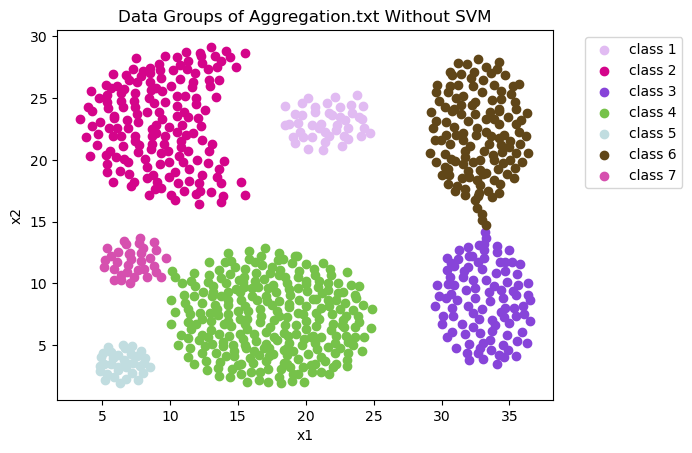

Best Parameters:  {'C': 1, 'degree': 2, 'gamma': 0.01, 'kernel': 'linear'}
Best Accuracy: 99.84%


C:\Anaconda\Lib\site-packages\mlxtend\plotting\decision_regions.py:346: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(


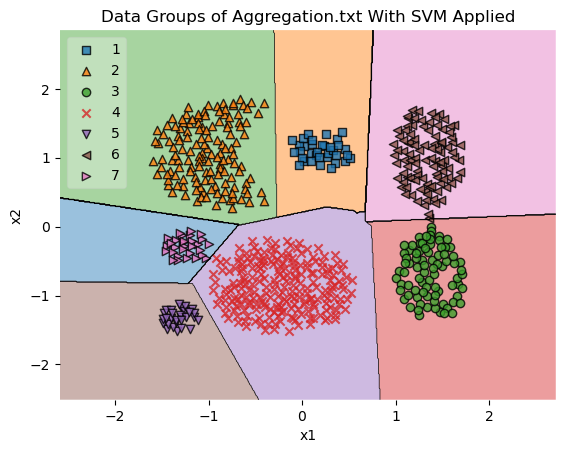

Accuracy of the model on test data: 0.9873417721518988


0.9873417721518988

In [146]:
classify('Aggregation.txt')

In [147]:
describe('Compound.txt')

Data Description:
         Feature1    Feature2       Label
count  399.000000  399.000000  399.000000
mean    22.215038   13.970677    3.543860
std      9.736752    4.743516    1.581125
min      7.150000    5.750000    1.000000
25%     14.100000    9.775000    2.000000
50%     18.950000   14.150000    4.000000
75%     32.725000   18.125000    5.000000
max     42.900000   22.750000    6.000000


,Feature1,Feature2,Label
0,26.75,22.15,1
1,29.80,22.15,1
2,31.55,21.10,1
3,27.70,20.85,1
4,29.90,19.95,1
...,...,...,...
394,15.85,9.95,6
395,15.35,9.90,6
396,15.60,9.45,6
397,15.30,9.15,6


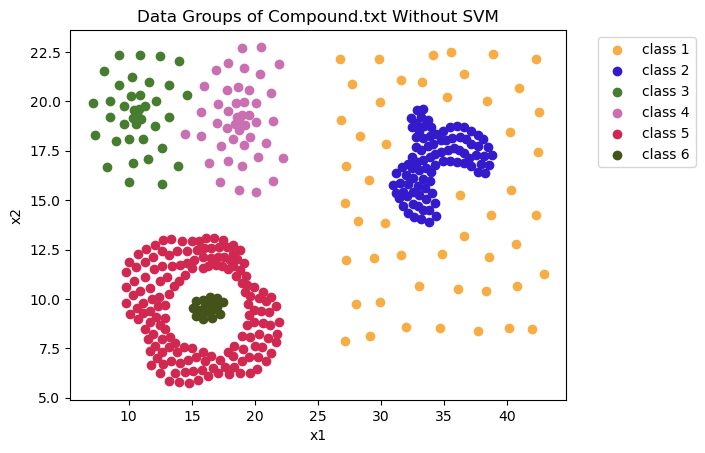

Best Parameters:  {'C': 10, 'degree': 2, 'gamma': 1, 'kernel': 'rbf'}
Best Accuracy: 98.44%


C:\Anaconda\Lib\site-packages\mlxtend\plotting\decision_regions.py:346: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(


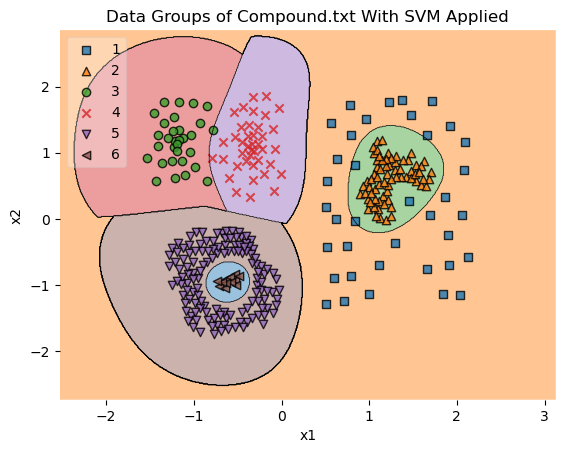

Accuracy of the model on test data: 0.9875


0.9875

In [148]:
classify('Compound.txt')

In [149]:
describe('Flame.txt')

Data Description:
         Feature1    Feature2       Label
count  240.000000  240.000000  240.000000
mean     7.323750   20.928542    1.637500
std      3.202509    3.383390    0.481727
min      0.500000   14.450000    1.000000
25%      5.250000   18.237500    1.000000
50%      7.300000   20.775000    2.000000
75%      9.312500   23.562500    2.000000
max     14.200000   27.800000    2.000000


,Feature1,Feature2,Label
0,1.85,27.80,1
1,1.35,26.65,1
2,1.40,23.25,2
3,0.85,23.05,2
4,0.50,22.35,2
...,...,...,...
235,7.50,26.20,1
236,7.50,25.65,1
237,7.05,25.85,1
238,6.90,27.15,1


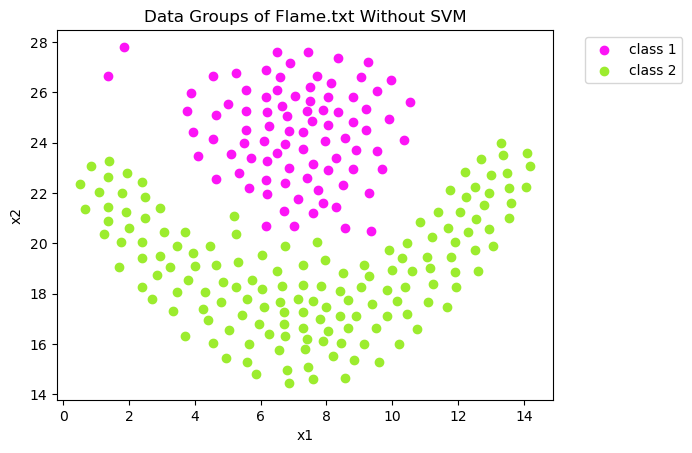

Best Parameters:  {'C': 1, 'degree': 2, 'gamma': 'auto', 'kernel': 'rbf'}
Best Accuracy: 98.96%


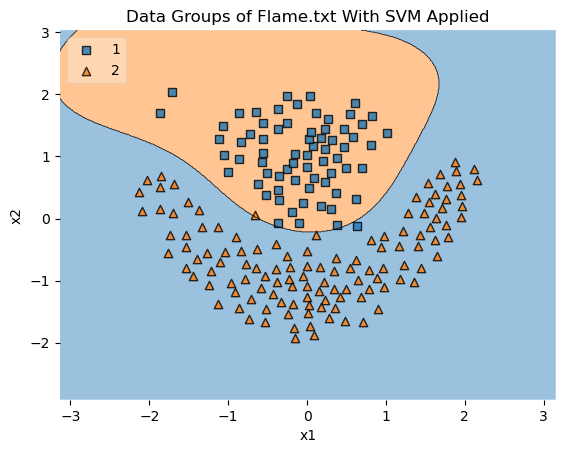

Accuracy of the model on test data: 1.0


1.0

In [150]:
classify('Flame.txt')

In [151]:
describe('Jain.txt')

Data Description:
         Feature1    Feature2       Label
count  373.000000  373.000000  373.000000
mean    24.330697   12.145979    1.260054
std      9.853372    6.605375    0.439253
min      0.750000    2.950000    1.000000
25%     17.350000    6.300000    1.000000
50%     23.150000   11.250000    1.000000
75%     33.350000   16.500000    2.000000
max     41.300000   27.850000    2.000000


,Feature1,Feature2,Label
0,0.85,17.45,2
1,0.75,15.60,2
2,3.30,15.45,2
3,5.25,14.20,2
4,4.90,15.65,2
...,...,...,...
368,38.75,16.85,1
369,39.00,16.60,1
370,38.25,17.35,1
371,39.50,16.95,1


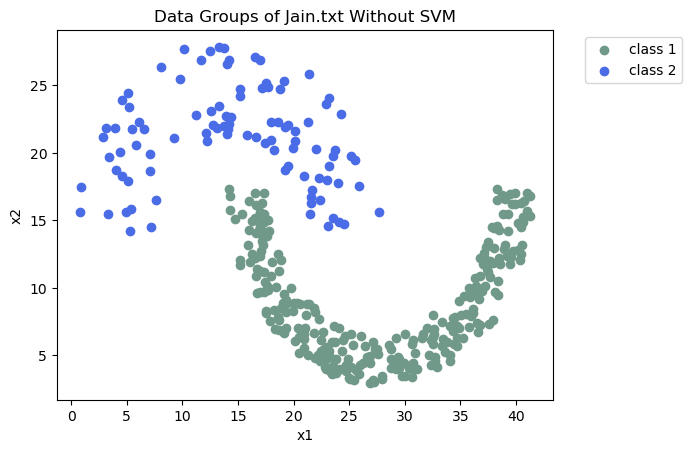

Best Parameters:  {'C': 1, 'degree': 2, 'gamma': 1, 'kernel': 'rbf'}
Best Accuracy: 100.00%


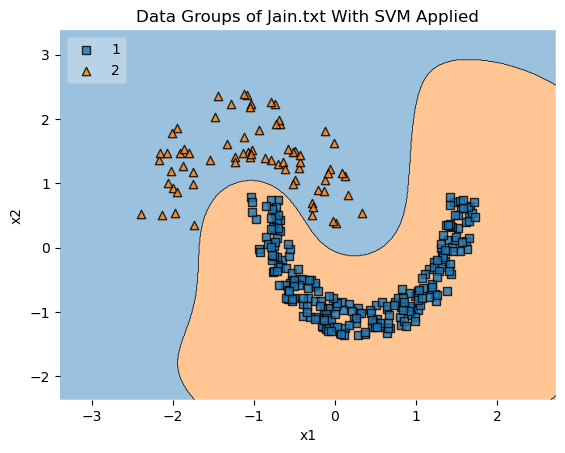

Accuracy of the model on test data: 1.0


1.0

In [152]:
classify('Jain.txt')

In [153]:
describe('Pathbased.txt')

Data Description:
         Feature1    Feature2       Label
count  300.000000  300.000000  300.000000
mean    18.846500   17.188500    1.943333
std      8.253238    5.855957    0.822015
min      4.700000    3.650000    1.000000
25%     11.287500   13.687500    1.000000
50%     19.100000   16.550000    2.000000
75%     26.250000   19.562500    3.000000
max     33.050000   31.750000    3.000000


,Feature1,Feature2,Label
0,11.25,5.05,1
1,10.95,4.70,1
2,9.85,5.80,1
3,9.80,5.75,1
4,9.15,6.80,1
...,...,...,...
295,17.50,18.05,2
296,16.65,17.50,2
297,15.45,17.30,2
298,15.45,17.80,2


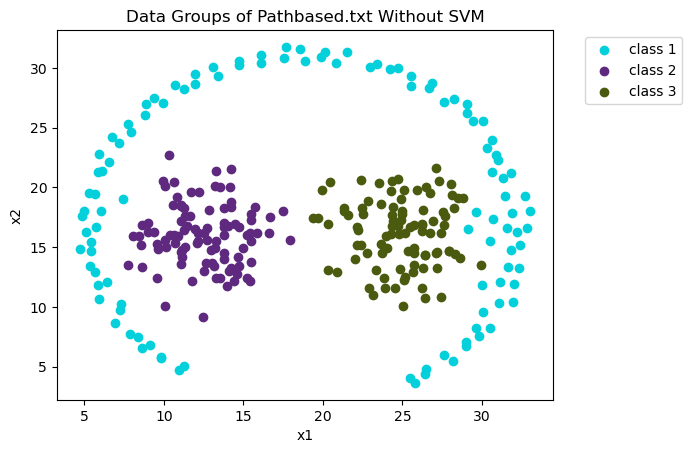

Best Parameters:  {'C': 1, 'degree': 2, 'gamma': 'auto', 'kernel': 'rbf'}
Best Accuracy: 98.75%


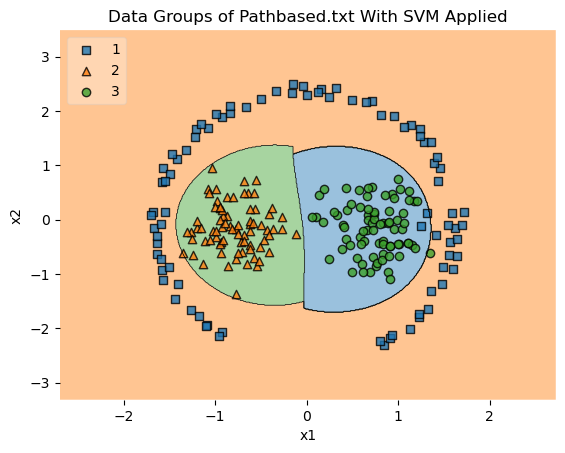

Accuracy of the model on test data: 0.9666666666666667


0.9666666666666667

In [154]:
classify('Pathbased.txt')

In [155]:
describe('Spiral.txt')

Data Description:
         Feature1    Feature2       Label
count  312.000000  312.000000  312.000000
mean    18.408173   16.344712    2.016026
std      7.299923    6.867232    0.815682
min      3.000000    2.900000    1.000000
25%     12.912500   11.337500    1.000000
50%     18.325000   16.050000    2.000000
75%     23.400000   21.362500    3.000000
max     31.950000   31.650000    3.000000


,Feature1,Feature2,Label
0,31.95,7.95,3
1,31.15,7.30,3
2,30.45,6.65,3
3,29.70,6.00,3
4,28.90,5.55,3
...,...,...,...
307,15.75,13.85,2
308,15.65,14.05,2
309,15.65,14.25,2
310,15.65,14.50,2


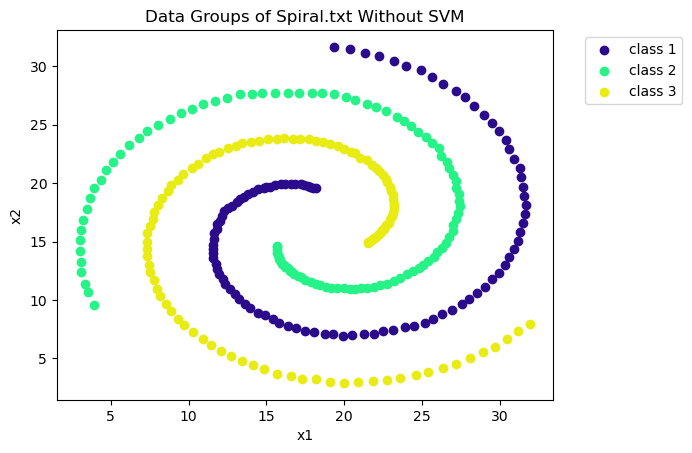

Best Parameters:  {'C': 1, 'degree': 2, 'gamma': 1, 'kernel': 'rbf'}
Best Accuracy: 100.00%


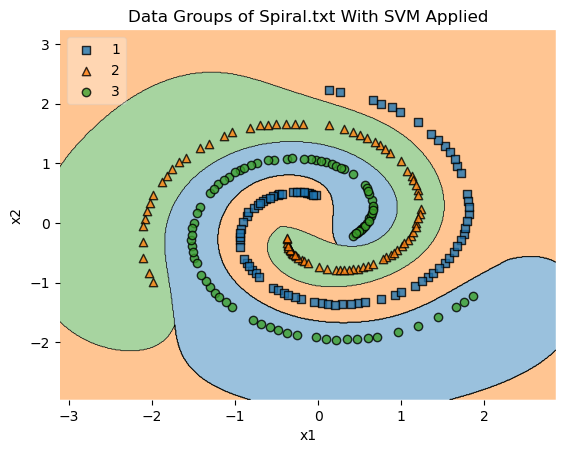

Accuracy of the model on test data: 1.0


1.0

In [156]:
classify('Spiral.txt')

**Comments on the graphs**: 
As we noticed from the graphs, that the datasets are differently separable, then different kernels will be applied on them. Here is the difference between the three kernels based on the dataset: <br>
__1) Linear Kernel:__<br>
    - Use when the data is linearly separable, meaning that a straight line can effectively separate the classes.<br>
    - Suitable for datasets where the classes can be well separated by a hyperplane.<br>
__2) Polynomial Kernel__:<br>
    - Use when the decision boundary is expected to be a polynomial function.<br>
    - Suitable for datasets with non-linear patterns, where a straight line is insufficient.<br>
__3) Gaussian (RBF) Kernel__:<br>
    - Use when the decision boundary is complex and may have non-linear patterns.<br>
    - Suitable for datasets with intricate relationships between features.